In [2]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [3]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

In [4]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [5]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'alarm.bif'))
true_dgm.draw()

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


In [6]:
data = true_dgm.rvs(size=1000)

In [7]:
gm.information.discrete_entropy(data[['VENTTUBE']])

0.75626425585627977

In [8]:
bic = gm.ScoreBIC(gm.MatrixGraph.from_networkx_DiGraph(true_dgm), data)

In [9]:
idx1 = list(data.columns).index('DISCONNECT')
idx2 = list(data.columns).index('VENTTUBE')
idx1, idx2

(1, 15)

In [10]:
vec = [False] * 37
vec[idx1] = True
bic(idx2, vec)

148.10536079894626

In [11]:
def entropy_stddev(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    for i in range(100):
        data = factor.rvs(n)
        results.append(gm.information.discrete_entropy(data))
    return np.std(results)

In [12]:
def dirichlet_variance(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    counts = n*factor.table.flatten()
    sum_counts = np.sum(counts)
    results = []
    for count in counts:
        results.append(n * (count * (sum_counts - count) / (sum_counts**2 * (sum_counts + 1))))
    return results
    
dirichlet_variance(1000, ['DISCONNECT', 'VENTTUBE'])

[0.083145896528015947,
 0.0009980019990146324,
 0.0063290176124113804,
 0.00099800199376766201,
 0.090376482247595494,
 0.19550058604296094,
 0.0089100899185391071,
 0.054037039288968004]

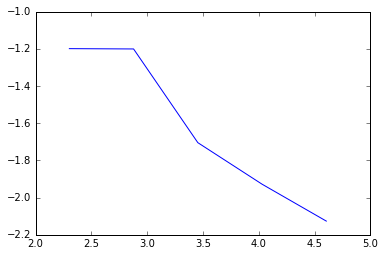

In [15]:
x = np.logspace(1, 2, num=5)
y = [np.log(entropy_stddev(n, ['DISCONNECT', 'VENTTUBE'])) for n in x]
plt.plot(np.log(x), y)

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.log(x).reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
def entropy_std(n, p):
    p_mle = np.random.binomial(n, p, size=100000).astype('float') / n
    p_mle = np.maximum(np.minimum(p_mle, 1 - 1e-5), 1e-5)
    entropy_mle = -(p_mle * np.log(p_mle) + (1 - p_mle)*np.log(1 - p_mle))
    return np.std(entropy_mle)

In [19]:
entropy_std(10000, 0.3)

0.0038911485109928354

[  1.00000000e+01   1.20679264e+01   1.45634848e+01   1.75751062e+01
   2.12095089e+01   2.55954792e+01   3.08884360e+01   3.72759372e+01
   4.49843267e+01   5.42867544e+01   6.55128557e+01   7.90604321e+01
   9.54095476e+01   1.15139540e+02   1.38949549e+02   1.67683294e+02
   2.02358965e+02   2.44205309e+02   2.94705170e+02   3.55648031e+02
   4.29193426e+02   5.17947468e+02   6.25055193e+02   7.54312006e+02
   9.10298178e+02   1.09854114e+03   1.32571137e+03   1.59985872e+03
   1.93069773e+03   2.32995181e+03   2.81176870e+03   3.39322177e+03
   4.09491506e+03   4.94171336e+03   5.96362332e+03   7.19685673e+03
   8.68511374e+03   1.04811313e+04   1.26485522e+04   1.52641797e+04
   1.84206997e+04   2.22299648e+04   2.68269580e+04   3.23745754e+04
   3.90693994e+04   4.71486636e+04   5.68986603e+04   6.86648845e+04
   8.28642773e+04   1.00000000e+05]


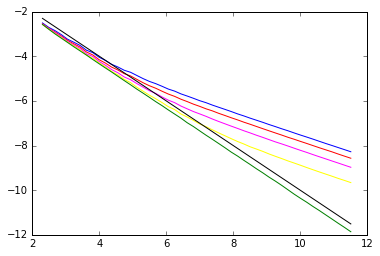

In [20]:
n = np.logspace(1, 5)
print(n)
#plt.plot(n, [1 / entropy_std(x, 0.5) for x in n], c='red')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.46)) for x in n], c='blue')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.47)) for x in n], c='red')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.48)) for x in n], c='magenta')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.49)) for x in n], c='yellow')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.5)) for x in n], c='green')
plt.plot(np.log(n), -np.log(n), c='black')
#plt.plot(n, [1 / entropy_std(x, 0.3) for x in n], c='green')
#plt.plot(n, [1 / entropy_std(x, 0.2) for x in n], c='magenta')
#plt.semilogx(n, [entropy_std(x, 0.3) for x in n], c='blue')
#plt.semilogx(n, [entropy_std(x, 0.1) for x in n], c='magenta')
#plt.semilogx(n, [entropy_std(x, 0.05) for x in n], c='green')

In [8]:
from scipy.special import digamma, gamma, gammaln, beta, betaln, polygamma
from scipy.misc import derivative

### Multivariate beta function

In [9]:
def log_mvbeta(*alphas):
    return np.sum([gammaln(alpha) for alpha in alphas]) - gammaln(np.sum(alphas))

In [10]:
log_mvbeta(3, 4), betaln(3, 4)

(-4.0943445622221013, -4.0943445622221004)

### Beta function derivatives

In [11]:
# since beta(a, b) can be very small we use logarithms

def log_mbeta1(a, b):
    """ 
    ln(-beta'(a, b))
    """
    return betaln(a, b) + np.log(-digamma(a) + digamma(a + b))

def beta1(a, b):
    return -np.exp(log_mbeta1(a, b))

def log_beta2(a, b):
    """
    ln(beta"(a, b))
    """
    return betaln(a, b) + np.log((digamma(a) - digamma(a + b))**2 + (polygamma(1, a) - polygamma(1, a + b)))

def beta2(a, b):
    return np.exp(log_beta2(a, b))

In [12]:
def naive_beta1(a, b):
    return beta(a, b)*(digamma(a) - digamma(a + b))

In [13]:
beta1(1, 1), beta1(1, 1000), beta1(1000, 1000), beta1(0.5, 0.5), log_mbeta1(1000, 1000)

(-1.0, -0.0074854708605429044, -0.0, -4.3551721806072017, -1388.8487538576146)

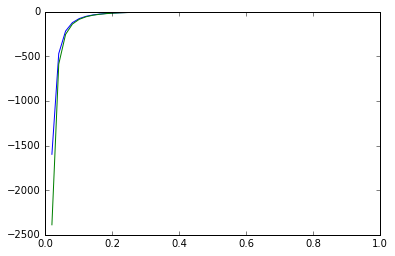

In [14]:
b = 100
x = np.linspace(0, 1, 50)
plt.plot(x, -(beta(x, b) - beta(x + 0.01, b)) / 0.01)
plt.plot(x, beta1(x, b))

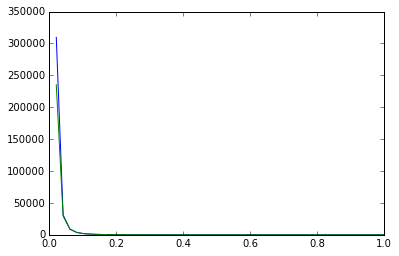

In [15]:
b = 100
x = np.linspace(0, 1, 50)
plt.plot(x, [derivative(lambda cx: beta(cx, b), x0, dx=0.01, n=2) for x0 in x])
plt.plot(x, beta2(x, b))

### Expectation of $p\,log(p)$

In [376]:
def log_mE_p_log_p(nx, ny):
    return log_mbeta1(nx + 1, ny) - betaln(nx, ny)

def E_p_log_p(nx, ny):
    return -np.exp(log_mE_p_log_p(nx, ny))

In [377]:
def empirical_E_p_log_p(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = np.zeros(factor.table.flatten().shape[0])
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() 
        result += p * np.log(p)
    result /= n_iter
    
    return result

In [378]:
def analytic_E_p_log_p(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = factor.table.flatten() * n
    
    for nx in counts:
        ny = n - nx
        results.append(E_p_log_p(nx, ny))
    
    return np.asarray(results)

In [379]:
sorted(empirical_E_p_log_p(1000, ['DISCONNECT']))

[-0.21750214200087975, -0.10728186846137991]

In [380]:
sorted(analytic_E_p_log_p(1000, ['DISCONNECT']))

[-0.22980933397642248, -0.094774481468880789]

### Expectation of $p^2\,log^2(p)$

In [21]:
def log_E_p2_log_p2(nx, ny):
    return log_beta2(nx + 2, ny) - betaln(nx, ny)

def E_p2_log_p2(nx, ny):
    return np.exp(log_E_p2_log_p2(nx, ny))

In [300]:
def empirical_E_p2_log_p2(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = np.zeros(factor.table.flatten().shape[0])
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() + 1e-5
        result += p**2 * np.log(p)**2
    result /= n_iter
    
    return result

In [327]:
def empirical2_E_p2_log_p2(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = np.zeros(factor.table.flatten().shape[0])
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() + 1e-5
    counts = counts / np.sum(counts)
    counts = counts * n
    n_iter = 100000
    for i in range(n_iter):
        p = np.random.dirichlet(counts)
        result += p**2 * np.log(p)**2
    result /= n_iter
    return result

In [328]:
def analytic_E_p2_log_p2(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = factor.table.flatten() * n
    
    for nx in counts:
        ny = n - nx
        results.append(E_p2_log_p2(nx, ny))
    
    return np.asarray(results)

In [329]:
sorted(analytic_E_p2_log_p2(1000, ['DISCONNECT', 'VENTLUNG']))

[7.6371285167352342e-05,
 0.0011289561749263347,
 0.0024065401883195023,
 0.0058819309338410449,
 0.014539735325870204,
 0.026236431661166591,
 0.060307180192844742,
 0.087629423056070202]

In [331]:
sorted(empirical2_E_p2_log_p2(1000, ['DISCONNECT', 'VENTLUNG']))

[7.3932912255028215e-05,
 0.001878707869181087,
 0.0022040806706114416,
 0.0029099803429482301,
 0.017202828933952787,
 0.029122011278604174,
 0.060118076155948656,
 0.08534200194651366]

In [333]:
sorted(empirical_E_p2_log_p2(1000, ['DISCONNECT', 'VENTLUNG']))

[0.00076352596873306407,
 0.0031329267133747723,
 0.0067528516665936855,
 0.013117003476830589,
 0.023428567460484103,
 0.02520501748021103,
 0.06033488889018436,
 0.066245435583368026]

### Expectation of $p_i\,log(p_i)\,p_j\,log(p_j)$

In [334]:
def log_E_pi_log_pi_pj_log_pj(nx, ny, nz):
    if nz > 0.5:
        #return log_mbeta1(ny + 1, nz) + log_mbeta1(nx + 1, ny + nz + 1) - log_mvbeta(nx, ny, nz)
        return np.log(nx) + np.log(ny) + np.log(ny + nz) - np.log(ny + nz) - np.log(nx + ny + nz + 1) - \
            np.log(nx + ny + nz) + np.log(-(digamma(ny + 1) - digamma(ny + nz + 1))) + \
            np.log(-(digamma(nx + 1) - digamma(nx + ny + nz + 2)))
    else:
        dg_xy = digamma(nx + ny + 2)
        log_deriv = betaln(nx + 1, ny + 1) + np.log((digamma(nx + 1) - dg_xy)*(digamma(ny + 1) - dg_xy) - \
                                                   polygamma(1, nx + ny + 2))
        return log_deriv - betaln(nx, ny)

def E_pi_log_pi_pj_log_pj(nx, ny, nz):
    return np.exp(log_E_pi_log_pi_pj_log_pj(nx, ny, nz))

In [335]:
E_pi_log_pi_pj_log_pj(3, 100, 500), E_pi_log_pi_pj_log_pj(100, 3, 500)

(0.007580538813283055, 0.0073385042900296739)

In [336]:
from itertools import combinations
def empirical_E_pi_log_pi_pj_log_pj(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    m = factor.table.flatten().shape[0]
    result = np.zeros((m*(m - 1)) / 2)
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() + 1e-5
        
        current = []
        for pi, pj in combinations(p, 2):
            current.append(pi * pj * np.log(pi) * np.log(pj))
        result += np.asarray(current)
            
    result /= n_iter
    
    return result

In [337]:
def analytic_E_pi_log_pi_pj_log_pj(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    m = factor.table.flatten().shape[0]
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    p = factor.table.flatten() + 1e-5
    p = p / np.sum(p)
    
    result = []
    for pi, pj in combinations(p, 2):
        nx = int(pi*n)
        ny = int(pj*n)
        nz = n - nx - ny
        result.append(E_pi_log_pi_pj_log_pj(nx, ny, nz))
    result = np.asarray(result)
    return result

In [338]:
sorted(empirical_E_pi_log_pi_pj_log_pj(2000, ['HR']))

[0.013957961793740439, 0.016362678394433866, 0.048102896879373816]

In [339]:
sorted(analytic_E_pi_log_pi_pj_log_pj(2000, ['HR']))

[0.0043352663485512494, 0.0092568365861747364, 0.017811568706768744]

In [340]:
sorted(empirical_E_pi_log_pi_pj_log_pj(2000, ['DISCONNECT', 'FIO2']))

[0.0054481559096168754,
 0.0082346913991243886,
 0.010088198612240907,
 0.016285218738137864,
 0.024607133830469644,
 0.028476255831236311]

In [341]:
sorted(analytic_E_pi_log_pi_pj_log_pj(2000, ['DISCONNECT', 'FIO2']))

[0.0034118318897573821,
 0.0036490968470340697,
 0.0058485178136283523,
 0.010954274137505471,
 0.013228619209686484,
 0.030501456017747831]

### Variance of p log p

In [384]:
def empirical_D_p_log_p(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = []
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() + 1e-5
        result.append(p * np.log(p))
        
    result = np.var(np.asarray(result), axis=0, ddof=1)
    
    return result

In [385]:
def analytic_D_p_log_p(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() * n
    
    for nx in counts:
        ny = n - nx
        nx = nx + 1
        ny = ny + 1
        results.append(E_p2_log_p2(nx, ny) - E_p_log_p(nx, ny)**2)
    
    return np.asarray(results)

In [388]:
def empirical2_D_p_log_p(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = []
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() + 1e-5
    counts = counts / np.sum(counts)
    counts = counts * n
    n_iter = 100000
    for i in range(n_iter):
        p = np.random.dirichlet(counts)
        result.append(p * np.log(p))
    result = np.var(result, axis=0, ddof=1)
    return result

In [389]:
sorted(analytic_D_p_log_p(1000, ['DISCONNECT', 'VENTLUNG']))

[4.9788594820697355e-05,
 9.1397769106160709e-05,
 0.00010253503894050442,
 0.0001306951225614702,
 0.00013565479765734797,
 0.00017529650028010393,
 0.00018673675664925352,
 0.00018733925727132394]

In [391]:
sorted(empirical2_D_p_log_p(1000, ['DISCONNECT', 'VENTLUNG']))

[3.0751316034869496e-05,
 8.102346942068452e-05,
 8.6694845757366912e-05,
 0.00010552657215472657,
 0.00011929158241200432,
 0.00015567569247920655,
 0.00018129487004389137,
 0.00018208564142840577]

In [387]:
sorted(empirical_D_p_log_p(1000, ['DISCONNECT', 'VENTLUNG']))

[0.00052269249582074899,
 0.0011754564164013455,
 0.0029149711289510262,
 0.0029674956301490563,
 0.0030035959334151403,
 0.0038573666371096798,
 0.0040585460157719303,
 0.0059966530496622225]

### Estimated entropy variance

In [443]:
def entropy_stddev(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    for i in range(100):
        data = factor.rvs(n)
        results.append(gm.information.discrete_entropy(data))
    return np.std(results)

In [468]:
def ed_entropy_stddev(n, variables):    
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = []
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() + 1e-5
    counts = counts / np.sum(counts)
    counts = counts * n
    n_iter = 100000
    for i in range(n_iter):
        p = np.random.dirichlet(counts)
        print p
        result.append(np.sum(p * np.log(p)))
    result = np.std(result, axis=0, ddof=1)
    return result

In [469]:
from itertools import product, combinations
def analytic_entropy_stddev(N, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    data = factor.rvs(N)
    fact = gm.TableFactor(factor.arguments, factor.scope).fit(data)
    counts = N * fact.table.flatten()
    
    result = 0.
    N = N + 3
    for nx, ny in combinations(counts, 2):
        nx = nx + 1
        ny = ny + 1
        
        #print 2*(E_pi_log_pi_pj_log_pj(nx, ny, N - nx - ny) - E_p_log_p(nx, N - nx)*E_p_log_p(ny, N - ny))
        #print E_p_log_p(nx, N - nx) 
        #print E_p_log_p(ny, N - ny)
        #print E_p_log_p(ny, N - ny) * E_p_log_p(nx, N - nx) 
        #print E_pi_log_pi_pj_log_pj(nx, ny, N - nx - ny)
        #print
        #result -= 2*(E_pi_log_pi_pj_log_pj(nx, ny, N - nx - ny) - \
        #             E_p_log_p(nx, N - nx)*E_p_log_p(ny, N - ny))
    
    N = N - 1
    for nx in counts:
        nx = nx + 1
        result += E_p2_log_p2(nx, N - nx) - E_p_log_p(nx, N - nx)**2
        
    return np.sqrt(result)

In [470]:
entropy_stddev(1000, ['VENTTUBE', 'VENTLUNG'])

0.042284301903146464

In [471]:
analytic_entropy_stddev(1000, ['VENTTUBE', 'VENTLUNG'])

0.039477438851839422

In [ ]:
ed_entropy_stddev(1000, ['VENTTUBE', 'VENTLUNG'])